In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
from pathlib import Path
warnings.filterwarnings('ignore')

In [13]:
# ============================================================================
# SETUP: DIRETÓRIO E PASTAS
# ============================================================================

# Se estiver em notebooks/, suba para raiz
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
    print(f"Mudando para: {os.getcwd()}")

# Criar pastas
Path('data/processed').mkdir(parents=True, exist_ok=True)
Path('data/raw').mkdir(parents=True, exist_ok=True)
Path('outputs/plots').mkdir(parents=True, exist_ok=True)

print(f"Working directory: {os.getcwd()}\n")

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

Working directory: /home/maricarminate/Projetos/anomaly-detector



In [14]:
# ============================================================================
# 1. CARREGAR E EXPLORAR DADOS
# ============================================================================

url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/NYC_taxi.csv"
try:
    df = pd.read_csv(url, parse_dates=['timestamp'])
    df.columns = ['timestamp', 'value']
except:
    print("Não conseguiu baixar. Use dados locais ou tente:")
    print("kaggle datasets download -d omerfarukcakir/nyc-taxi-trip-duration")

print("=" * 60)
print("EXPLORAÇÃO INICIAL")
print("=" * 60)
print(f"\nShape: {df.shape}")
print(f"\nPrimeiras linhas:\n{df.head(10)}")
print(f"\nTipos de dados:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

Não conseguiu baixar. Use dados locais ou tente:
kaggle datasets download -d omerfarukcakir/nyc-taxi-trip-duration
EXPLORAÇÃO INICIAL

Shape: (4368, 5)

Primeiras linhas:
            timestamp  value  hour  day_of_week day_name
0 2016-01-01 00:00:00    546     0            4   Friday
1 2016-01-01 01:00:00    566     1            4   Friday
2 2016-01-01 02:00:00    503     2            4   Friday
3 2016-01-01 03:00:00    479     3            4   Friday
4 2016-01-01 04:00:00    323     4            4   Friday
5 2016-01-01 05:00:00    142     5            4   Friday
6 2016-01-01 06:00:00    133     6            4   Friday
7 2016-01-01 07:00:00    113     7            4   Friday
8 2016-01-01 08:00:00    124     8            4   Friday
9 2016-01-01 09:00:00    114     9            4   Friday

Tipos de dados:
timestamp      datetime64[ns]
value                   int64
hour                    int32
day_of_week             int32
day_name               object
dtype: object

Missing values:
time

In [15]:
# ============================================================================
# 2. ESTATÍSTICAS DESCRITIVAS
# ============================================================================

print("\n" + "=" * 60)
print("ESTATÍSTICAS DESCRITIVAS")
print("=" * 60)
print(f"\n{df['value'].describe()}")
print(f"\nSkewness: {df['value'].skew():.4f}")
print(f"Kurtosis: {df['value'].kurtosis():.4f}")




ESTATÍSTICAS DESCRITIVAS

count    4368.000000
mean      333.938645
std       151.294318
min         0.000000
25%       223.000000
50%       376.000000
75%       443.000000
max       655.000000
Name: value, dtype: float64

Skewness: -0.5776
Kurtosis: -0.7560


In [16]:
# ============================================================================
# 3. VERIFICAR PERIODICIDADE
# ============================================================================

print("\n" + "=" * 60)
print("INFORMAÇÕES TEMPORAIS")
print("=" * 60)
print(f"Data início: {df['timestamp'].min()}")
print(f"Data fim: {df['timestamp'].max()}")
print(f"Duração: {(df['timestamp'].max() - df['timestamp'].min()).days} dias")
print(f"Frequência: {pd.infer_freq(df['timestamp'])}")



INFORMAÇÕES TEMPORAIS
Data início: 2016-01-01 00:00:00
Data fim: 2016-06-30 23:00:00
Duração: 181 dias
Frequência: h



✓ Salvo: outputs/plots/01_eda_overview.png


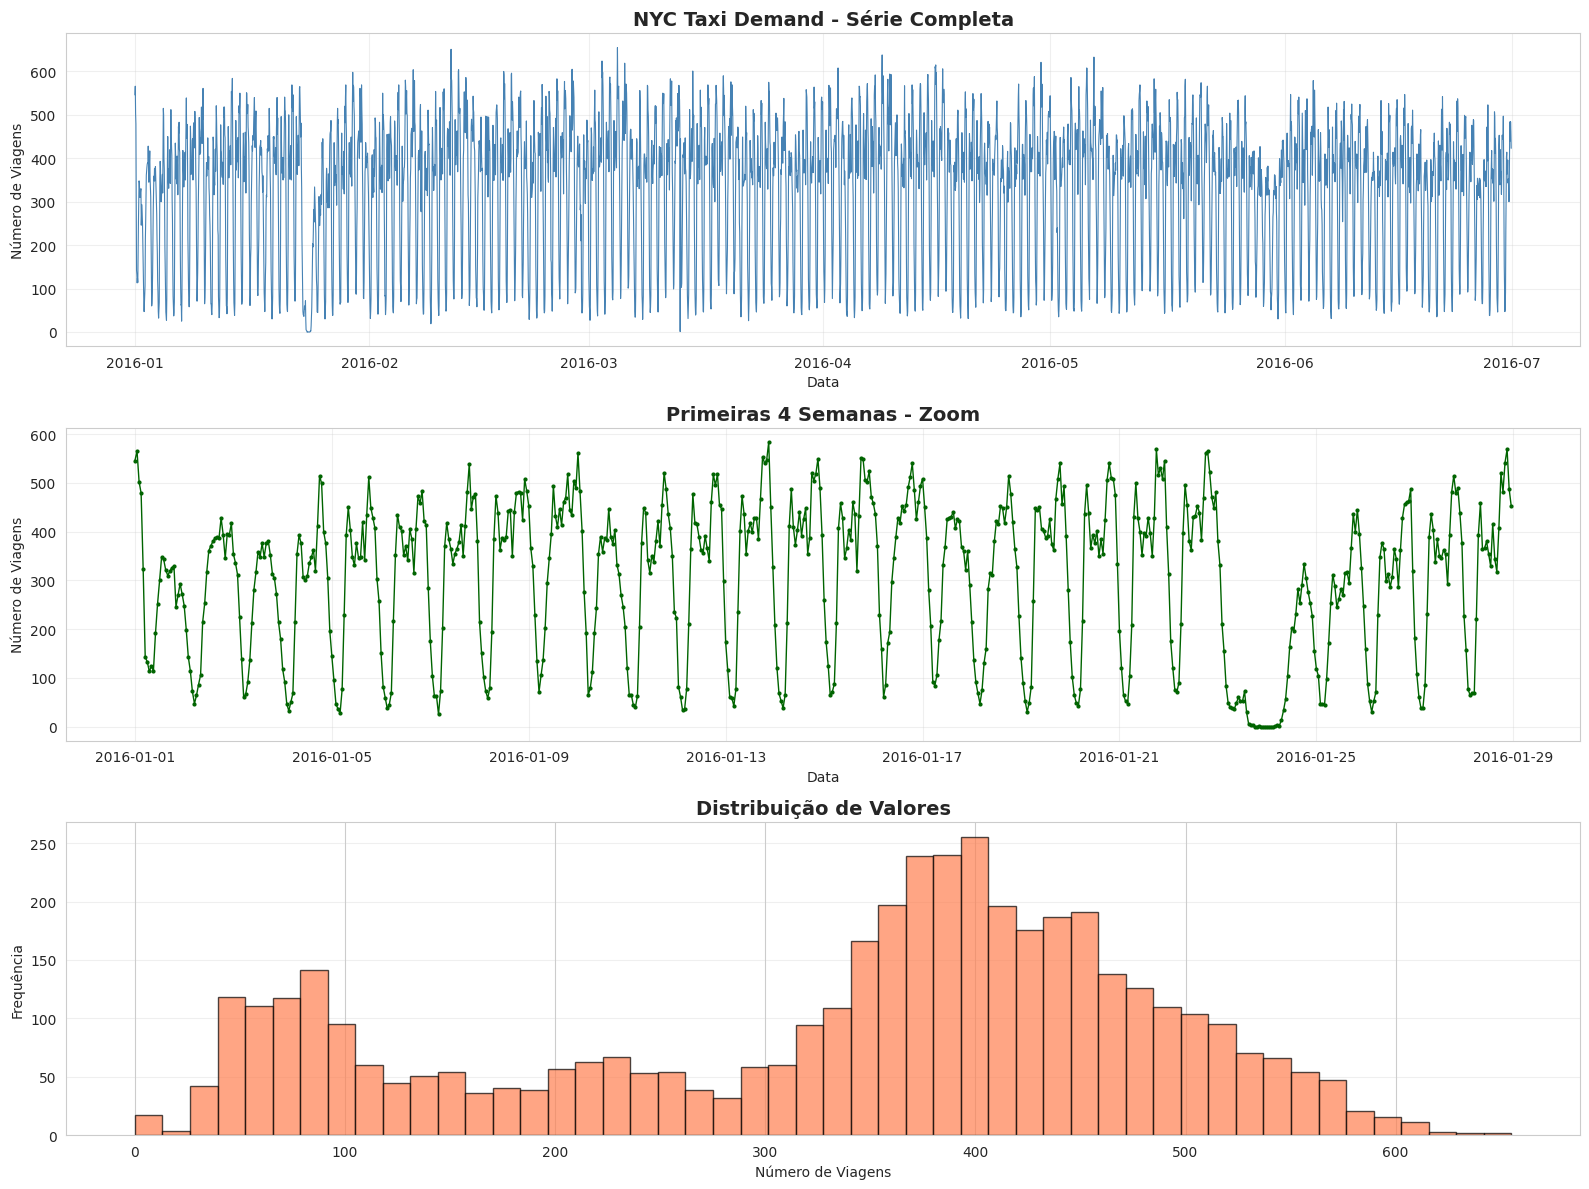

In [17]:
# ============================================================================
# 4. VISUALIZAÇÕES
# ============================================================================


fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Série completa
axes[0].plot(df['timestamp'], df['value'], linewidth=0.8, color='steelblue')
axes[0].set_title('NYC Taxi Demand - Série Completa', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Número de Viagens')
axes[0].grid(True, alpha=0.3)

# Zoom: primeiras 4 semanas
first_month = df.head(24 * 28)
axes[1].plot(first_month['timestamp'], first_month['value'], linewidth=1, color='darkgreen', marker='o', markersize=2)
axes[1].set_title('Primeiras 4 Semanas - Zoom', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Número de Viagens')
axes[1].grid(True, alpha=0.3)

# Distribuição
axes[2].hist(df['value'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[2].set_title('Distribuição de Valores', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Número de Viagens')
axes[2].set_ylabel('Frequência')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outputs/plots/01_eda_overview.png', dpi=300, bbox_inches='tight')
print("\n✓ Salvo: outputs/plots/01_eda_overview.png")
plt.show()

✓ Salvo: outputs/plots/01_temporal_patterns.png


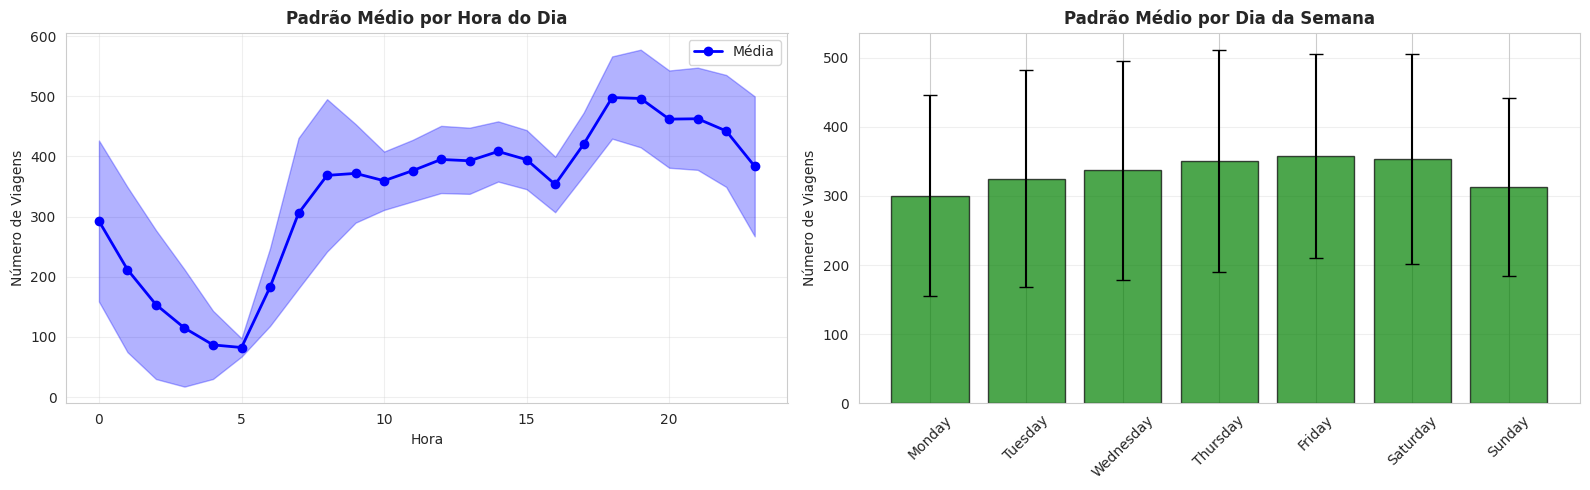

In [18]:
# ============================================================================
# 5. PADRÕES TEMPORAIS
# ============================================================================

df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_name'] = df['timestamp'].dt.day_name()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Padrão por hora do dia
hourly_pattern = df.groupby('hour')['value'].agg(['mean', 'std'])
axes[0].plot(hourly_pattern.index, hourly_pattern['mean'], marker='o', linewidth=2, color='blue', label='Média')
axes[0].fill_between(hourly_pattern.index, 
                      hourly_pattern['mean'] - hourly_pattern['std'],
                      hourly_pattern['mean'] + hourly_pattern['std'],
                      alpha=0.3, color='blue')
axes[0].set_title('Padrão Médio por Hora do Dia', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Hora')
axes[0].set_ylabel('Número de Viagens')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Padrão por dia da semana
daily_pattern = df.groupby('day_name')['value'].agg(['mean', 'std'])
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_pattern = daily_pattern.reindex(day_order)
axes[1].bar(range(len(daily_pattern)), daily_pattern['mean'], color='green', alpha=0.7, edgecolor='black')
axes[1].errorbar(range(len(daily_pattern)), daily_pattern['mean'], 
                 yerr=daily_pattern['std'], fmt='none', color='black', capsize=5)
axes[1].set_xticks(range(len(daily_pattern)))
axes[1].set_xticklabels(daily_pattern.index, rotation=45)
axes[1].set_title('Padrão Médio por Dia da Semana', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Número de Viagens')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outputs/plots/01_temporal_patterns.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/01_temporal_patterns.png")
plt.show()



DETECÇÃO VISUAL DE ANOMALIAS

Pontos com Z-score > 3: 0
✓ Salvo: outputs/plots/01_anomalies_visual.png


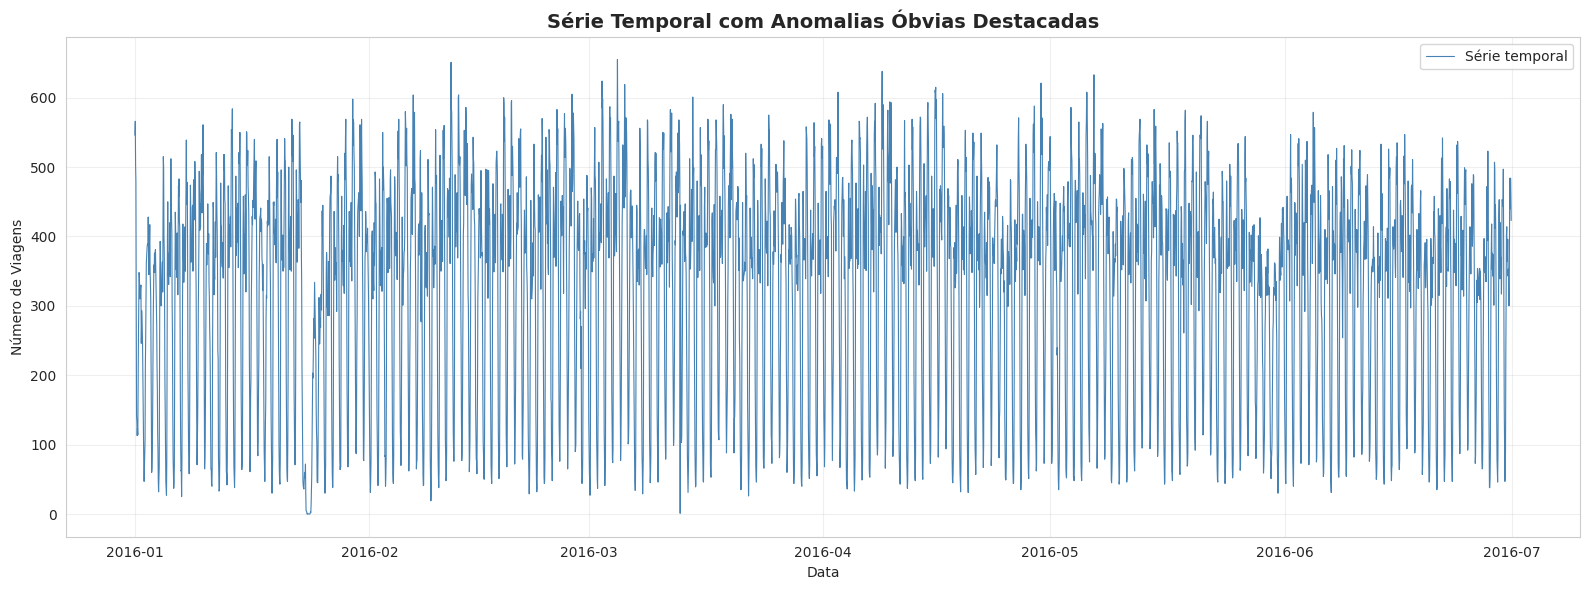

In [19]:
# ============================================================================
# 6. DETECÇÃO VISUAL DE ANOMALIAS
# ============================================================================

print("\n" + "=" * 60)
print("DETECÇÃO VISUAL DE ANOMALIAS")
print("=" * 60)

# Z-score simples para identificar outliers óbvios
z_scores = np.abs((df['value'] - df['value'].mean()) / df['value'].std())
anomalies_visual = df[z_scores > 3]

print(f"\nPontos com Z-score > 3: {len(anomalies_visual)}")
if len(anomalies_visual) > 0:
    print("\nAnomalias detectadas (primeiras 10):")
    print(anomalies_visual[['timestamp', 'value']].head(10))

# Visualizar anomalias
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df['timestamp'], df['value'], linewidth=0.8, color='steelblue', label='Série temporal')
if len(anomalies_visual) > 0:
    ax.scatter(anomalies_visual['timestamp'], anomalies_visual['value'], 
              color='red', s=100, marker='x', linewidth=2, label='Anomalias (Z-score > 3)', zorder=5)
ax.set_title('Série Temporal com Anomalias Óbvias Destacadas', fontsize=14, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('Número de Viagens')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/plots/01_anomalies_visual.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/01_anomalies_visual.png")
plt.show()


SEPARAÇÃO TREINO/TESTE

Treino: 3494 pontos (2016-01-01 00:00:00 a 2016-05-25 13:00:00)
Teste: 874 pontos (2016-05-25 14:00:00 a 2016-06-30 23:00:00)
✓ Salvo: outputs/plots/01_train_test_split.png


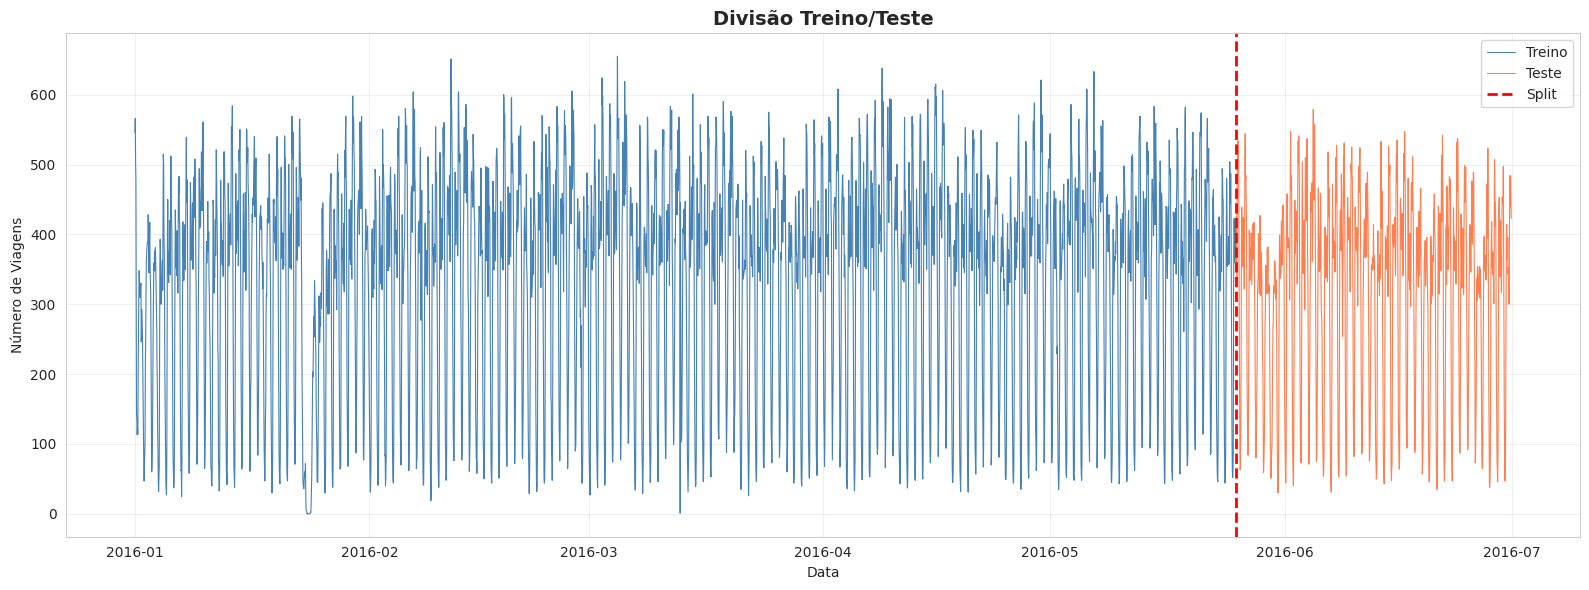

In [20]:
# ============================================================================
# 7. PREPARAR TREINO/TESTE
# ============================================================================

print("\n" + "=" * 60)
print("SEPARAÇÃO TREINO/TESTE")
print("=" * 60)

split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx][['timestamp', 'value']].copy()
test = df.iloc[split_idx:][['timestamp', 'value']].copy()

print(f"\nTreino: {len(train)} pontos ({train['timestamp'].min()} a {train['timestamp'].max()})")
print(f"Teste: {len(test)} pontos ({test['timestamp'].min()} a {test['timestamp'].max()})")

# Visualizar split
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train['timestamp'], train['value'], linewidth=0.8, color='steelblue', label='Treino')
ax.plot(test['timestamp'], test['value'], linewidth=0.8, color='coral', label='Teste')
ax.axvline(x=df['timestamp'].iloc[split_idx], color='red', linestyle='--', linewidth=2, label='Split')
ax.set_title('Divisão Treino/Teste', fontsize=14, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('Número de Viagens')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/plots/01_train_test_split.png', dpi=300, bbox_inches='tight')
print("✓ Salvo: outputs/plots/01_train_test_split.png")
plt.show()

In [21]:
# ============================================================================
# 8. SALVAR DADOS PREPARADOS
# ============================================================================

df_clean = df[['timestamp', 'value']].copy()
df_clean.to_csv('data/processed/nyc_taxi_clean.csv', index=False)
train.to_csv('data/processed/nyc_taxi_train.csv', index=False)
test.to_csv('data/processed/nyc_taxi_test.csv', index=False)

print("\n✓ Arquivos salvos em data/processed/:")
print("  - nyc_taxi_clean.csv")
print("  - nyc_taxi_train.csv")
print("  - nyc_taxi_test.csv")

print("\n" + "=" * 60)
print("DIA 1 CONCLUÍDO!")
print("=" * 60)


✓ Arquivos salvos em data/processed/:
  - nyc_taxi_clean.csv
  - nyc_taxi_train.csv
  - nyc_taxi_test.csv

DIA 1 CONCLUÍDO!
